#### Author: Arun Ramesh, University of Houston. https://rpglab.github.io/people/Arun-Venkatesh-Ramesh/
#### Source webpage: https://rpglab.github.io/resources/FL-ML-R-SCUC_Python/
#### If you use any codes/data here for your work, please cite the following paper: 
#####       Arun Venkatesh Ramesh and Xingpeng Li, “Feasibility Layer Aided Machine Learning Approach for Day-Ahead Operations”, IEEE Transactions on Power Systems, Apr. 2023.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
np.random.seed(1)

import sys
nums = np.arange(2000)
np.set_printoptions(threshold=sys.maxsize)

import csv
import time
from timeit import default_timer as timer

In [4]:
##### data set 24 Bus 8 Prd

dfX_24 = pd.read_csv("demand24BusWBCorr24Prd.txt")
dfY_24 = pd.read_csv("commitment24BusWBCorr24Prd.txt")

print(dfX_24.info)
print(dfY_24.info)

x = dfX_24.to_numpy()
#x = np.delete(x,0,1) #delete column one sample number
x = x/100
#print(x[1])

y = dfY_24.to_numpy()
#y = np.delete(y,0,1) #delete column one sample number
#print(y[1])

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 20% for validation data that we never train over.
split_at = len(x) - len(x) // 5
(x_train, x_test) = x[:split_at], x[split_at:]
(y_train, y_test) = y[:split_at], y[split_at:]


print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

print(indices)

#print(x_train[1])
#print(y_train[1])

#print(x_test[1])
#print(y_test[1])

<bound method DataFrame.info of       88.95783123018604  79.89731138266708  74.13152602515503  \
0             70.842516          63.627074          59.035430   
1            102.465737          92.029412          85.388114   
2            103.989126          93.397641          86.657605   
3             67.207355          60.362162          56.006130   
4             93.489390          83.967322          77.907825   
...                 ...                ...                ...   
1794          76.630947          71.840607          65.623164   
1795          78.200704          68.007509          65.384535   
1796          87.128307          77.862964          72.939164   
1797          77.172511          71.257205          65.388665   
1798          94.566878          82.100946          75.922571   

      126.84727786526528  58.4815371976223  121.90517613025493  \
0             101.016180         46.572395           97.080485   
1             146.108550         67.361734          140

In [5]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1440, 576)
(1440, 792)
(359, 576)
(359, 792)


In [6]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros(shape=(dim,792))
    b = 0
    return w, b

In [7]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / ( 1 + np.exp(-z))
    return s

In [8]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    
    m = X.shape[0]
    
    #print(m)
    
    #print(w.shape)
    #print(X.shape)
    #print(b)
    b = np.sum(b) #try b.T
    #print(b)
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)             # compute activation
    #print(A.shape)
    #print(Y.shape)
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost
    #print(cost.shape)
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == (792,))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [9]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # Record the costs
        #if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        #if print_cost and i % 100 == 0:
        #    print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [10]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = X.shape[1]
    #Y_prediction = np.zeros((792, m))
    w = w.reshape(X.shape[0], 792)
    b = np.sum(b)
    
    # Compute vector "A" predicting the probabilities commitment
    A = sigmoid(np.dot(w.T, X) + b)
    #print (A.shape)
    #print(A.T)        
    return A

In [11]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [12]:
x_train = x_train.T
y_train = y_train.T

x_test = x_test.T
y_test = y_test.T

In [13]:
print (x_train.shape)
print (y_train.shape)

learning_rates = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05]
#learning_rates = [0.01]
models = {}
for i in learning_rates:
    start = timer()
    print ("learning rate is: ",i)
    models[i] = model(x_train, y_train, x_test, y_test, num_iterations = 1000, learning_rate = i, print_cost = True)
    end = timer()
    print("training time: ",end - start)
    print ("-------------------------------------------------------")

(576, 1440)
(792, 1440)
learning rate is:  0.001
train accuracy: 94.84619470400345 %
test accuracy: 94.93997875149915 %
training time:  87.86160290000004
-------------------------------------------------------
learning rate is:  0.003
train accuracy: 95.2737447026796 %
test accuracy: 95.37363311977859 %
training time:  86.15549179999994
-------------------------------------------------------
learning rate is:  0.005
train accuracy: 95.51031158958968 %
test accuracy: 95.61690024698231 %
training time:  86.65880850000008
-------------------------------------------------------
learning rate is:  0.008
train accuracy: 95.71553617199382 %
test accuracy: 95.8294577411283 %
training time:  88.1274899
-------------------------------------------------------
learning rate is:  0.01
train accuracy: 95.80877498037887 %
test accuracy: 95.92618047671192 %
training time:  87.13582940000003
-------------------------------------------------------
learning rate is:  0.03
train accuracy: 96.0637828263935

<ipython-input-8-9f7c41a8f593>:31: RuntimeWarning: divide by zero encountered in log
  cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost
<ipython-input-8-9f7c41a8f593>:31: RuntimeWarning: invalid value encountered in multiply
  cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost


train accuracy: 96.08634309789433 %
test accuracy: 96.2723047884715 %
training time:  86.68162519999998
-------------------------------------------------------


In [14]:
for i in learning_rates:
    print ("learning rate is: ",i)
    w = models[i]["w"]
    b = models[i]["b"]
    A_prediction_test = predict(w, b, x_test)
    A_prediction_test = A_prediction_test.T
    
    m = A_prediction_test.shape[0]
    Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
    P = 0.7

    for j in range(m):
        for i in range(A_prediction_test.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_test[j, i] >= P:
                Y_test_hackFull[j, i] = 1
            
            else:
                Y_test_hackFull[j, i] = 0
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
    A_prediction_train = predict(w, b, x_train)
    A_prediction_train = A_prediction_train.T
    
    m = A_prediction_train.shape[0]
    Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
    for j in range(m):
        for i in range(A_prediction_train.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_train[j, i] >= P:
                Y_train_hackFull[j, i] = 1
            
            else:
                Y_train_hackFull[j, i] = 0
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
    print ("-------------------------------------------------------")
   

learning rate is:  0.001
test accuracy: 96.72807461804676 %
train accuracy: 96.57915965207631 %
-------------------------------------------------------
learning rate is:  0.003
test accuracy: 96.9936130103261 %
train accuracy: 96.80371422558923 %
-------------------------------------------------------
learning rate is:  0.005
test accuracy: 97.17298331504459 %
train accuracy: 96.9302398989899 %
-------------------------------------------------------
learning rate is:  0.008
test accuracy: 97.39455839734391 %
train accuracy: 97.11235620089786 %
-------------------------------------------------------
learning rate is:  0.01
test accuracy: 97.43746658788442 %
train accuracy: 97.16128296857464 %
-------------------------------------------------------
learning rate is:  0.03
test accuracy: 96.58000619003404 %
train accuracy: 96.43614969135803 %
-------------------------------------------------------
learning rate is:  0.05
test accuracy: 96.14951745870965 %
train accuracy: 96.02141203703704

In [15]:
i = 0.01
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_test = predict(w, b, x_test)
A_prediction_test = A_prediction_test.T
    
m = A_prediction_test.shape[0]
Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
P = 0.7

for j in range(m):
    for k in range(A_prediction_test.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_test[j, k] >= P:
            Y_test_hackFull[j, k] = 1
            
        else:
            Y_test_hackFull[j, k] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
A_prediction_train = predict(w, b, x_train)
A_prediction_train = A_prediction_train.T
    
m = A_prediction_train.shape[0]
Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
for j in range(m):
    for k in range(A_prediction_train.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_train[j, k] >= P:
            Y_train_hackFull[j, k] = 1
            
        else:
            Y_train_hackFull[j, k] = 0
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
print ("-------------------------------------------------------")

learning rate is:  0.01
test accuracy: 97.43746658788442 %
train accuracy: 97.16128296857464 %
-------------------------------------------------------


In [35]:
with open("commitment24Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_test_hackFull)

In [20]:
x_test_round = np.around(x_test, decimals=4)
x_test_round = x_test_round.T
with open("demand24Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_test_round)

In [21]:
A_prediction_test_round = np.around(A_prediction_test, decimals=6)
#A_prediction_test_round = A_prediction_test_round.T
with open("probabilities24Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_test_round)

In [38]:
with open("UgtAct24Bus24PrdTest4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(y_test.T)

In [39]:
x_train_round = np.around(x_train, decimals=3)
x_train_round = x_train_round.T
with open("demand24PrdTrainSample4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(x_train_round)

In [40]:
A_prediction_train_round = np.around(A_prediction_train, decimals=6)
with open("probabilities24Bus24PrdTrainSample4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(A_prediction_train_round)

In [41]:
with open("UgtAct24Bus24PrdTrain4Ampl.txt","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(y_train.T)

In [42]:
npindice = np.reshape(indices, (1,1499))
with open("indiceshorizontal.csv","w+",newline="") as my_csv: #index(indices) 1201-1500 test case 299 samples
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(npindice) 
with open("indicesvertical.csv","w+",newline="") as my_csv: #index(indices) 1201-1500 test case 299 samples
    csvWriter = csv.writer(my_csv,delimiter='\n')
    csvWriter.writerows(npindice)

ValueError: cannot reshape array of size 1799 into shape (1,1499)

In [16]:
##### data set 24 Bus 8 Prd

dfXoF_24 = pd.read_csv("demand24Bus24Prd_outofSample.txt")

print(dfXoF_24.info)

xoF = dfXoF_24.to_numpy()
#x = np.delete(x,0,1) #delete column one sample number
xoF = xoF/100

# Explicitly set apart 20% for validation data that we never train over.
split_at = 100
(x_oF, x_restoF) = xoF[:split_at], xoF[split_at:]

print(len(x_oF))

x_oF = x_oF.T

<bound method DataFrame.info of       90.13728903773256  80.95663922833387  75.11440753144379  \
0             67.493145          60.618843          56.244287   
1            107.022171          96.121765          89.185142   
2            108.926408          97.832052          90.772007   
3             62.949194          56.537702          52.457662   
4             95.801737          86.044153          79.834781   
...                 ...                ...                ...   
1494         101.205071          83.534633          79.818072   
1495          84.521178          78.343324          74.534879   
1496          92.821142          84.133780          89.090335   
1497          78.007085          86.473328          79.682256   
1498          85.612332          75.013867          67.089895   

      128.52909733158162  59.25692149702789  123.5214701628187  \
0              96.240225          44.370493          92.490606   
1             152.605688          70.357168         146

In [17]:
i = 0.01
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_oF = predict(w, b, x_oF)
A_prediction_oF = A_prediction_oF.T


learning rate is:  0.01


In [18]:
A_prediction_round_oF = np.around(A_prediction_oF, decimals=6)
#A_prediction_test_round = A_prediction_test_round.T
with open("probabilities24Bus24PrdSample4Ampl_outofSample.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_round_oF)

In [20]:
x_round_oF = np.around(x_oF, decimals=4)
x_round_oF = x_round_oF.T
with open("demand24Bus24PrdSample4Ampl_outofSample.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_round_oF)

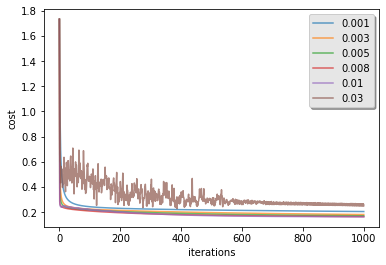

[[1.73286795 1.25602435 0.97820297 0.8064884  0.69327368 0.61435643
  0.55680057 0.51326384 0.47933965 0.45225177 0.43017706 0.41187523
  0.39647648 0.38335472 0.37204884 0.36221249 0.3535808  0.3459481
  0.33915238 0.33306446 0.32758011 0.3226144  0.31809746 0.31397129
  0.31018742 0.30670498 0.30348932 0.30051086 0.29774422 0.29516749
  0.29276166 0.29051017 0.28839852 0.28641395 0.28454522 0.28278237
  0.28111654 0.27953984 0.27804518 0.27662625 0.27527732 0.27399326
  0.27276941 0.27160156 0.27048585 0.26941881 0.26839725 0.26741824
  0.26647912 0.26557743 0.26471091 0.2638775  0.26307526 0.26230243
  0.26155737 0.26083855 0.26014457 0.25947411 0.25882594 0.25819894
  0.25759204 0.25700424 0.25643462 0.25588231 0.25534649 0.2548264
  0.25432133 0.25383059 0.25335356 0.25288963 0.25243824 0.25199887
  0.251571   0.25115416 0.25074791 0.25035181 0.24996547 0.24958851
  0.24922056 0.24886129 0.24851035 0.24816745 0.24783229 0.24750459
  0.24718408 0.24687051 0.24656363 0.24626322 0.24

In [20]:
plt.clf()

NCost = int(models[0.003]["num_iterations"])#/100)

costarray_full = np.zeros((len(learning_rates),NCost))
costarray_single = np.zeros(NCost)

#print (NCost)
for i in range(6):#len(learning_rates)):
    costarray_single = np.zeros(NCost)
    for j in range(NCost):
        #print (j)
        costarray_single[j] = np.mean(np.squeeze(models[learning_rates[i]]["costs"][j])) 
    costarray_full[i] = costarray_single
    plt.plot(costarray_full[i], label= str(models[learning_rates[i]]["learning_rate"]),alpha=0.7)
    #print (np.squeeze(models[i]["costs"][2]))

#plt.plot(costarray_full[i], label= str(models[0.001]["learning_rate"]), alpha=1)
#plt.plot(np.squeeze(models[0.001]["costs"][1]), label= str(models[0.001]["learning_rate"]))
plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

print (costarray_full)



In [40]:
plt.clf()
#grid=[x for x in range(7)]
i = 0
for gg,graph in enumerate(costarray_full[0:6]):
    lw=10-8*gg/len(costarray_full)
    ls=['-','--','-.',':'][gg%4]
    #plt.plot(grid,graph,label=str(models[learning_rates[i]]["learning_rate"]), linestyle=ls, linewidth=lw)
    plt.plot(graph,label=str(models[learning_rates[i]]["learning_rate"]), linestyle=ls, linewidth=lw)
    i = i+1
    
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='center right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.preprocessing import StandardScaler # data normalization
#X_var = StandardScaler().fit(X_var).transform(x_train.T)

TrainScore = []
TestScore = []
NgxNt = y_train.shape[0]
m_Tr = x_train.shape[1]
m_Ts = x_test.shape[1]

Y_hat_tr_skln_pred = np.zeros((m_Tr,NgxNt))
Y_hat_ts_skln_pred = np.zeros((m_Ts,NgxNt))

start = timer()
for i in range(NgxNt):
    #print ("Ng*Nt: ",i)   
    
    if set([0,1]).issubset(set(y_train[i])):      
        
        #logreg = MultiOutputRegressor(LogisticRegression(multi_class='multinomial', solver='lbfgs'))
        logreg = LogisticRegression(random_state=0, solver='liblinear', max_iter = 100)
        logreg.fit(x_train.T,y_train[i]) #original shape before transposed
        Y_hat_tr_skln_pred[:,i] = logreg.predict(x_train.T)
        TrainScore.append(logreg.score(x_train.T,y_train[i]))
        Y_hat_ts_skln_pred[:,i] = logreg.predict(x_test.T)
        TestScore.append(logreg.score(x_test.T,y_test[i]))
    
    else:
        
        if set([0]).issubset(set(y_train[i])):
            Y_hat_tr_skln_pred[:,i] = np.zeros(m_Tr)
        else:
            Y_hat_tr_skln_pred[:,i] = np.ones(m_Tr)
        
        if set([0]).issubset(set(y_test[i])):
            Y_hat_ts_skln_pred[:,i] = np.zeros(m_Ts)
        else:
            Y_hat_ts_skln_pred[:,i] = np.ones(m_Ts)
            
        TrainScore.append(1)
        TestScore.append(1)
end = timer()
print("training time: ",end - start)
print ("-------------------------------------------------------")

print("training Score: ", np.mean(TrainScore))
print("testing Score: ", np.mean(TestScore))

print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_hat_tr_skln_pred)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_hat_ts_skln_pred)) * 100))


training time:  15.807164499999999
-------------------------------------------------------
training Score:  0.9795717592592592
testingg Score:  0.9755413668457147
train accuracy: 97.95717592592592 %
test accuracy: 97.55202526941657 %


In [8]:
x_test_round = np.around(x_test, decimals=4)
x_test_round = x_test_round.T
with open("demand24Bus24PrdTestSampleSKLRN4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_test_round)

In [9]:
with open("commitment24Bus24PrdTestSampleSKLRN4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_hat_ts_skln_pred)

In [97]:
start = timer()
print ("learning rate is 0.01 ")
models[i] = model(x_train, y_train, x_test, y_test, num_iterations = 100, learning_rate = 0.01, print_cost = True)
end = timer()
print("training time: ",end - start)
print ("-------------------------------------------------------")

learning rate is 0.01 
train accuracy: 95.16864033907224 %
test accuracy: 95.17634472888518 %
training time:  8.177797299998929
-------------------------------------------------------


In [106]:
i = 0.01
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_test = predict(w, b, x_test)
A_prediction_test = A_prediction_test.T
    
m = A_prediction_test.shape[0]
Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
P = 0.5

for j in range(m):
    for k in range(A_prediction_test.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_test[j, k] >= P:
            Y_test_hackFull[j, k] = 1
            
        else:
            Y_test_hackFull[j, k] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
A_prediction_train = predict(w, b, x_train)
A_prediction_train = A_prediction_train.T
    
m = A_prediction_train.shape[0]
Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
for j in range(m):
    for k in range(A_prediction_train.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_train[j, k] >= P:
            Y_train_hackFull[j, k] = 1
            
        else:
            Y_train_hackFull[j, k] = 0
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
print ("-------------------------------------------------------")

learning rate is:  0.01
test accuracy: 97.44941049288876 %
train accuracy: 97.4961069023569 %
-------------------------------------------------------
